# Data loading and formating

In [1]:
import rasterio
from rasterio import plot
import numpy as np

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


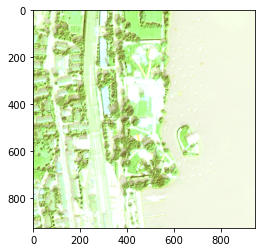

<AxesSubplot:>

In [2]:
# read the pixels' values (RGB + IR)
dataset = rasterio.open('Zurich_dataset_v1.0/images_tif/zh3.tif')
image = dataset.read([1,2,3,4])
plot.show(image)

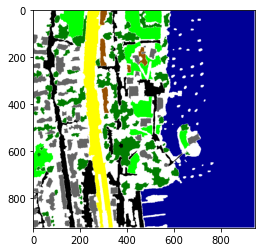

<AxesSubplot:>

In [3]:
# read and reformat the labels
dataset = rasterio.open('Zurich_dataset_v1.0/groundtruth/zh3_GT.tif')
labels = dataset.read([1,2,3])
plot.show(labels)

In [4]:
# put the data into a "good shape"
print("size of the image: ",image.shape, "and of the ground truth: ", labels.shape)
x = image.transpose(2,1,0).reshape(-1,4)
y = np.sum(labels.transpose(2,1,0).reshape(-1,3), axis=1)
print("size of the dataset: ",x.shape, "and of the labels: ", y.shape)

size of the image:  (4, 926, 943) and of the ground truth:  (3, 926, 943)
size of the dataset:  (873218, 4) and of the labels:  (873218,)


In [5]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=2000, random_state=1)

In [6]:
x_train.shape

(2000, 4)

# Part 1: do a k-nn on the training set only and compute the precision

In [7]:
# perform the knn, with k=1
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
nn_1 = KNeighborsClassifier(n_neighbors=1)
nn_1.fit(x_train, y_train)
y_pred = nn_1.predict(x_train)
accuracy_score(y_train, y_pred)

1.0

In [8]:
acc = []
for i in range(1,101):
    nn = KNeighborsClassifier(n_neighbors=i)
    nn.fit(x_train, y_train)
    acc.append(accuracy_score(y_train, nn.predict(x_train)))

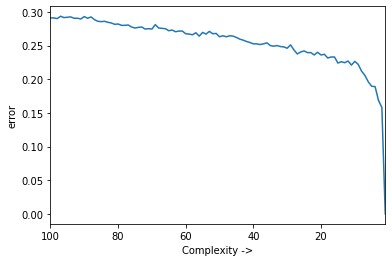

In [9]:
import matplotlib.pyplot as plt
plt.plot(np.arange(1,101), 1-np.array(acc))
plt.xlabel("Complexity ->")
plt.ylabel("error")
plt.xlim(100, 1)
plt.show()

# Part 2: do a k-nn on the test set only and compute the accuracy on the test set

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=2000, test_size=2000, random_state=1)

In [11]:
acc_test = []
for i in range(1,101):
    nn = KNeighborsClassifier(n_neighbors=i)
    nn.fit(x_train, y_train)
    acc_test.append(accuracy_score(y_test, nn.predict(x_test)))

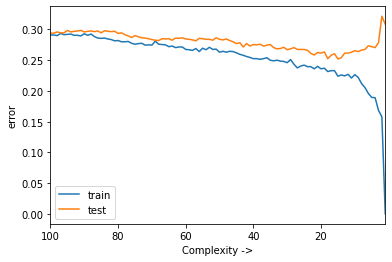

In [12]:
plt.plot(np.arange(1,101), 1-np.array(acc), label='train')
plt.plot(np.arange(1,101), 1-np.array(acc_test), label='test')
plt.legend()
plt.xlabel("Complexity ->")
plt.ylabel("error")
plt.xlim(100, 1)
plt.show()

In [13]:
print(np.argmax(acc_test))
print(np.max(acc_test))
#do you think that it is a good classifier?

14
0.748


<class 'numpy.uint64'>
[  0 125 150 230 255 300 510 765]


[143, 171, 780, 13, 104, 115, 94, 580]

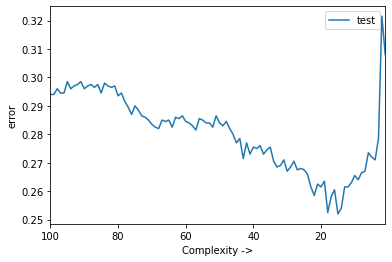

In [202]:

plt.plot(np.arange(1,101), 1-np.array(acc_test), label='test')
plt.legend()
plt.xlabel("Complexity ->")
plt.ylabel("error")
plt.xlim(100, 1)
plt.show()

# Part 3: use a validation set to choose the best parameter

In [214]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=2000, test_size=2000, random_state=1)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, train_size=1600, test_size=400, random_state=1)

In [215]:
acc_valid = []
for i in range(1,101):
    nn = KNeighborsClassifier(n_neighbors=i)
    nn.fit(x_train, y_train)
    acc_valid.append(accuracy_score(y_valid, nn.predict(x_valid)))

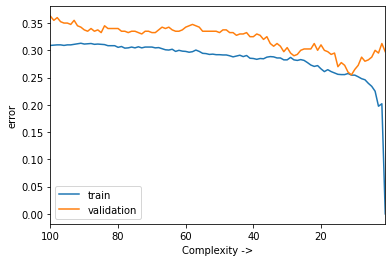

In [216]:
plt.plot(np.arange(1,101), 1-np.array(acc), label='train')
plt.plot(np.arange(1,101), 1-np.array(acc_valid), label='validation')
plt.legend()
plt.xlabel("Complexity ->")
plt.ylabel("error")
plt.xlim(100, 1)
plt.show()

In [217]:
print(np.argmax(acc_valid))
print(np.max(acc_valid))
#do you think that it is a good classifier?

10
0.745


In [219]:
# generalization error
nn = KNeighborsClassifier(n_neighbors=10)
nn.fit(x_train, y_train)
print(accuracy_score(y_test, nn.predict(x_test)))

0.746


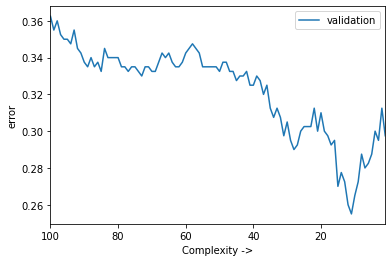

In [220]:
#plt.plot(np.arange(1,101), 1-np.array(acc), label='train')
plt.plot(np.arange(1,101), 1-np.array(acc_valid), label='validation')
plt.legend()
plt.xlabel("Complexity ->")
plt.ylabel("error")
plt.xlim(100, 1)
plt.show()

# Part 4: cross validation

In [222]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=2000, test_size=2000, random_state=1)

In [227]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)

In [228]:
def compute_cv(k):
    acc_valid = 0
    acc_train = 0
    nn = KNeighborsClassifier(n_neighbors=k)
    for train_index, valid_index in kf.split(x_train):
        x_train_cv, x_valid_cv = x_train[train_index], x_train[valid_index]
        y_train_cv, y_valid_cv = y_train[train_index], y_train[valid_index]
        #compute the error on the validation set
        nn.fit(x_train_cv, y_train_cv)
        res = nn.predict(x_valid_cv)
        acc_valid += np.mean(res == y_valid_cv)
        #compute the error on the training set
        res = nn.predict(x_train_cv)
        acc_train += np.mean(res == y_train_cv)
    acc_valid /=5
    acc_train /= 5
    return acc_train, acc_valid


In [229]:
all_acc_train = []
all_acc_valid = []
for k in range(1,101):
    acc_train, acc_valid = compute_cv(k)
    all_acc_train.append(acc_train)
    all_acc_valid.append(acc_valid)
    

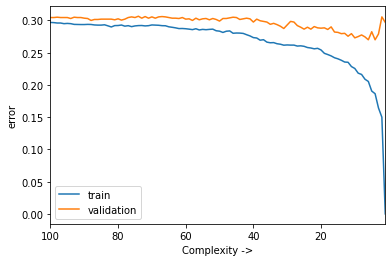

In [230]:
plt.plot(np.arange(1,101), 1-np.array(all_acc_train), label='train')
plt.plot(np.arange(1,101), 1-np.array(all_acc_valid), label='validation')
plt.legend()
plt.xlabel("Complexity ->")
plt.ylabel("error")
plt.xlim(100, 1)
plt.show()

In [231]:
print(np.argmax(all_acc_valid))
print(np.max(all_acc_valid))


3
0.73


In [237]:
nn = KNeighborsClassifier(n_neighbors=3)
#we do it on the whole training set
nn.fit(x_train, y_train)
print(accuracy_score(y_test, nn.predict(x_test)))

0.7215


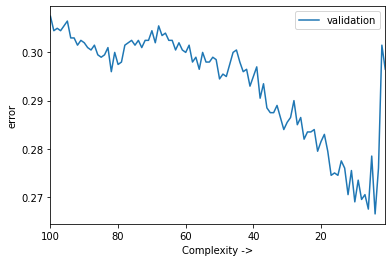

In [235]:
from sklearn.model_selection import cross_val_score
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=2000, test_size=2000, random_state=1)
all_acc_valid = []
for k in range(1,101):
    nn = KNeighborsClassifier(n_neighbors=k)
    all_acc_valid.append(np.mean(cross_val_score(nn, x_train, y_train, cv=5)))
plt.plot(np.arange(1,101), 1-np.array(all_acc_valid), label='validation')
plt.legend()
plt.xlabel("Complexity ->")
plt.ylabel("error")
plt.xlim(100, 1)
plt.show()


In [236]:
np.argmax(all_acc_valid)

3

# part 5: confusion matrix

In [241]:
from sklearn.metrics import confusion_matrix
#on the lines, the true label and on the col, the estimated one
c = confusion_matrix(y_test, nn.predict(x_test))
print(c)
print(np.round(c/np.sum(c,1),2))


[[ 92   1   0   0   3   5  10  32]
 [  0  84   0   0   9   0   0  78]
 [  1   0 774   0   0   0   0   5]
 [  1   0   0  10   0   0   0   2]
 [  3  14   0   0  62   0   0  25]
 [ 10   0   0   0   0  60   9  36]
 [ 30   0   0   0   0   9  42  13]
 [ 66  81  23   0  46  33  12 319]]
[[0.64 0.01 0.   0.   0.03 0.04 0.11 0.06]
 [0.   0.49 0.   0.   0.09 0.   0.   0.13]
 [0.01 0.   0.99 0.   0.   0.   0.   0.01]
 [0.01 0.   0.   0.77 0.   0.   0.   0.  ]
 [0.02 0.08 0.   0.   0.6  0.   0.   0.04]
 [0.07 0.   0.   0.   0.   0.52 0.1  0.06]
 [0.21 0.   0.   0.   0.   0.08 0.45 0.02]
 [0.46 0.47 0.03 0.   0.44 0.29 0.13 0.55]]


In [175]:
np.sum(confusion_matrix(y_test, nn.predict(x_test)), 1)

array([143, 171, 780,  13, 104, 115,  94, 580])

# part 6: new chip

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


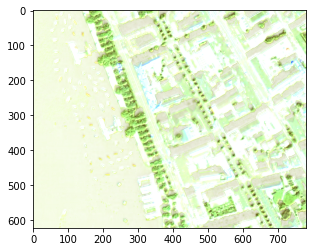

<AxesSubplot:>

In [190]:
# read the pixels' values (RGB + IR)
dataset = rasterio.open('Zurich_dataset_v1.0/images_tif/zh12.tif')
image = dataset.read([1,2,3,4])
plot.show(image)

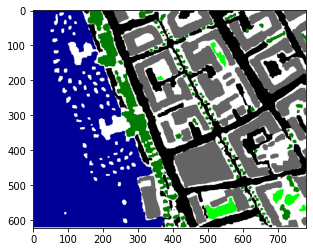

<AxesSubplot:>

In [191]:
# read and reformat the labels
dataset = rasterio.open('Zurich_dataset_v1.0/groundtruth/zh12_GT.tif')
labels = dataset.read([1,2,3])
plot.show(labels)

In [192]:
# put the data into a "good shape"
print("size of the image: ",image.shape, "and of the ground truth: ", labels.shape)
x_new = image.transpose(2,1,0).reshape(-1,4)
y_new = np.sum(labels.transpose(2,1,0).reshape(-1,3), axis=1)
print("size of the dataset: ",x.shape, "and of the labels: ", y.shape)

size of the image:  (4, 622, 782) and of the ground truth:  (3, 622, 782)
size of the dataset:  (873218, 4) and of the labels:  (873218,)


In [193]:
x_new_sub, _, y_new_sub, _ = train_test_split(x_new, y_new, train_size=2000, random_state=1)

In [194]:
c_new = confusion_matrix(y_new_sub, nn.predict(x_new_sub))
print(c_new)
c_new / (np.sum(c_new, axis=1))

[[159   2   9   0   0  10  56 124]
 [  2  56   0   0   1   0   0  61]
 [  0   0 592   0   0   0   0   9]
 [  0   0   0   0   0   0   0   0]
 [  3   6   0   1   6   0   0   6]
 [125   4  12   5   0  79  67 146]
 [  0   0   0   0   0   0   0   0]
 [ 83  25  46   1   0  27  35 242]]


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


array([[0.44166667, 0.01666667, 0.01497504,        nan, 0.        ,
        0.02283105,        inf, 0.27015251],
       [0.00555556, 0.46666667, 0.        ,        nan, 0.04545455,
        0.        ,        nan, 0.1328976 ],
       [0.        , 0.        , 0.98502496,        nan, 0.        ,
        0.        ,        nan, 0.01960784],
       [0.        , 0.        , 0.        ,        nan, 0.        ,
        0.        ,        nan, 0.        ],
       [0.00833333, 0.05      , 0.        ,        inf, 0.27272727,
        0.        ,        nan, 0.0130719 ],
       [0.34722222, 0.03333333, 0.01996672,        inf, 0.        ,
        0.1803653 ,        inf, 0.31808279],
       [0.        , 0.        , 0.        ,        nan, 0.        ,
        0.        ,        nan, 0.        ],
       [0.23055556, 0.20833333, 0.0765391 ,        inf, 0.        ,
        0.06164384,        inf, 0.52723312]])